# CNN Model for Composer Classification

#### Daniel, Tyler and Rahul

#### Import

- Import libraries: Handling MIDI files, data manipulation, machine learning, and neural network construction.
- Configure logging: Capture and log warnings or errors during MIDI file processing.
- Suppress warnings: Ignore specific runtime warnings to avoid clutter.

In [1]:
import os
import warnings
import pretty_midi
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Path to the "composers" folder
DATA_DIR = 'composers'

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(filename='midi_processing.log', level=logging.WARNING)

#### Define data processing functions

- Load MIDI file: Reads a MIDI file and returns its data.
- Extract features: Extracts musical features like number of instruments, tempo, pitch-related features, rhythm-related features, harmony-related features, and dynamics.
- Process data: Processes all MIDI files in the specified directory, extracts features, and stores them in a DataFrame.

#### Prepare Dataset for Training


- Process data: Uses the defined functions to process MIDI files.
- Encode labels: Uses LabelEncoder to convert composer names to numeric labels.
- Split dataset: Splits the dataset into training and testing sets.
- Scale features: Standardizes the features.
- Convert to tensors: Converts the data to PyTorch tensors.

In [2]:
def load_midi_file(file_path):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            midi_data = pretty_midi.PrettyMIDI(file_path)
        return midi_data
    except Exception as e:
        logging.warning(f"Error loading {file_path}: {str(e)}")
        return None

def extract_advanced_features(pm):
    if pm is None:
        return None

    features = {}

    try:
        # Basic features
        features['num_instruments'] = len(pm.instruments)
        features['tempo'] = pm.estimate_tempo()
        features['total_duration'] = pm.get_end_time()

        # Pitch-related features
        pitches = [note.pitch for instrument in pm.instruments for note in instrument.notes]
        features['pitch_range'] = max(pitches) - min(pitches) if pitches else 0
        features['avg_pitch'] = np.mean(pitches) if pitches else 0
        features['pitch_std'] = np.std(pitches) if pitches else 0

        # Rhythm-related features
        note_durations = [note.end - note.start for instrument in pm.instruments for note in instrument.notes]
        features['avg_note_duration'] = np.mean(note_durations) if note_durations else 0
        features['note_duration_std'] = np.std(note_durations) if note_durations else 0

        # Harmony-related features
        features['unique_pitch_classes'] = len(set([pitch % 12 for pitch in pitches])) if pitches else 0

        # Dynamics
        velocities = [note.velocity for instrument in pm.instruments for note in instrument.notes]
        features['avg_velocity'] = np.mean(velocities) if velocities else 0
        features['velocity_std'] = np.std(velocities) if velocities else 0

        # Get pitch class histogram
        pitch_class_histogram = pm.get_pitch_class_histogram()
        for i, freq in enumerate(pitch_class_histogram):
            features[f'pitch_class_{i}'] = freq

        return features
    except Exception as e:
        logging.warning(f"Error extracting features: {str(e)}")
        return None

def process_data(data_dir):
    data = []
    for composer in os.listdir(data_dir):
        composer_path = os.path.join(data_dir, composer)
        if os.path.isdir(composer_path):
            for file in os.listdir(composer_path):
                if file.endswith('.mid'):
                    file_path = os.path.join(composer_path, file)
                    midi_data = load_midi_file(file_path)
                    features = extract_advanced_features(midi_data)
                    if features:
                        features['composer'] = composer
                        data.append(features)

    return pd.DataFrame(data)

df = process_data(DATA_DIR)

# Encode labels
le = LabelEncoder()
df['composer_encoded'] = le.fit_transform(df['composer'])

# Split the dataset
X = df.drop(['composer', 'composer_encoded'], axis=1).values
y = df['composer_encoded'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

#### Define Dataset Class and DataLoader

- Custom Dataset class: Handles data augmentation during training.
- DataLoaders: Efficiently loads data in batches during training and testing.

In [5]:
class ComposerDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment:
            x = self.augment_features(x)
        return x, self.y[idx]

    def augment_features(self, x):
        # Add random noise
        noise = torch.randn_like(x) * 0.1
        x = x + noise
        # Random scaling
        scale = torch.randn(1) * 0.1 + 1
        x = x * scale
        return x

train_dataset = ComposerDataset(X_train, y_train, augment=True)
test_dataset = ComposerDataset(X_test, y_test, augment=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#### Define the CNN Model

- CNN architecture: Defines a Convolutional Neural Network with three convolutional layers, max-pooling layers, dropout layers, and two fully connected layers.

In [6]:
class ComposerCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ComposerCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(256 * (input_size // 8), 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

#### Train and Evaluate the Model

- Train model: Trains the model over several epochs, recording the training loss and test accuracy.
- Evaluate model: Evaluates the model on the test dataset and saves the best model based on test accuracy.

In [7]:
# Training and evaluation
input_size = X_train.shape[1]
num_classes = len(le.classes_)
model = ComposerCNN(input_size=input_size, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

num_epochs = 100
train_losses = []
test_accuracies = []
best_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = correct / total
    test_accuracies.append(accuracy)

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, LR: {current_lr:.6f}')

    scheduler.step(accuracy)
    if optimizer.param_groups[0]['lr'] != current_lr:
        print(f'Learning rate decreased to {optimizer.param_groups[0]["lr"]:.6f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'New best model saved with accuracy: {best_accuracy:.4f}')

print(f'Training completed. Best accuracy: {best_accuracy:.4f}')


Epoch [1/100], Loss: 1.0358, Test Accuracy: 0.6209, LR: 0.001000
New best model saved with accuracy: 0.6209
Epoch [2/100], Loss: 0.8484, Test Accuracy: 0.6797, LR: 0.001000
New best model saved with accuracy: 0.6797
Epoch [3/100], Loss: 0.7774, Test Accuracy: 0.6895, LR: 0.001000
New best model saved with accuracy: 0.6895
Epoch [4/100], Loss: 0.6929, Test Accuracy: 0.7484, LR: 0.001000
New best model saved with accuracy: 0.7484
Epoch [5/100], Loss: 0.5810, Test Accuracy: 0.7941, LR: 0.001000
New best model saved with accuracy: 0.7941
Epoch [6/100], Loss: 0.5474, Test Accuracy: 0.7745, LR: 0.001000
Epoch [7/100], Loss: 0.5424, Test Accuracy: 0.7843, LR: 0.001000
Epoch [8/100], Loss: 0.4598, Test Accuracy: 0.8431, LR: 0.001000
New best model saved with accuracy: 0.8431
Epoch [9/100], Loss: 0.4045, Test Accuracy: 0.8595, LR: 0.001000
New best model saved with accuracy: 0.8595
Epoch [10/100], Loss: 0.3824, Test Accuracy: 0.8562, LR: 0.001000
Epoch [11/100], Loss: 0.3374, Test Accuracy: 0.8

#### Evaluation and Visualization

- Load best model: Loads the best model for evaluation.
- Evaluate model: Computes and prints the final test accuracy.
- Confusion matrix: Plots the confusion matrix to visualize the model's performance.
- Plot training metrics: Plots the training loss and test accuracy over epochs.

Final Test Accuracy: 0.9020


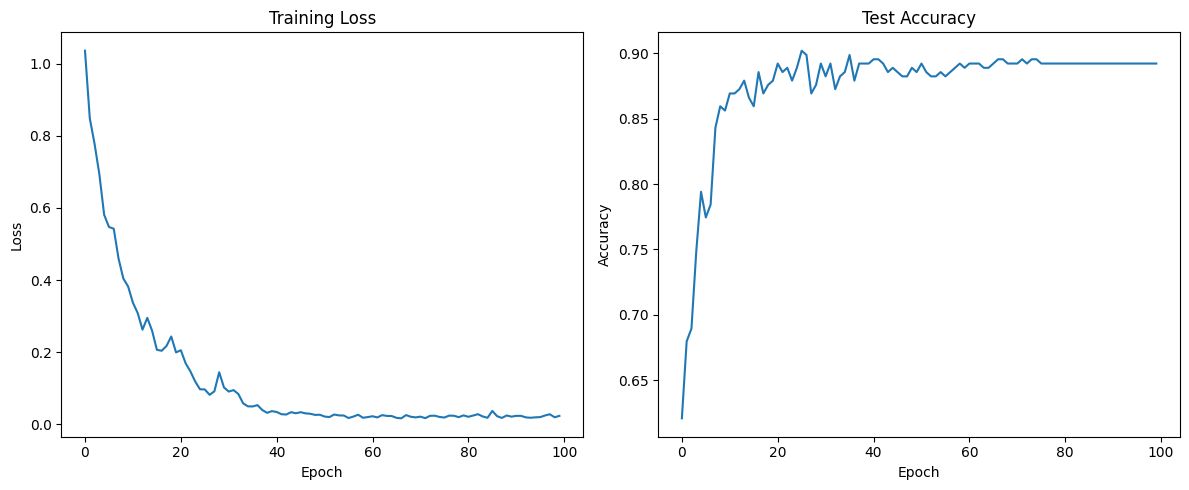

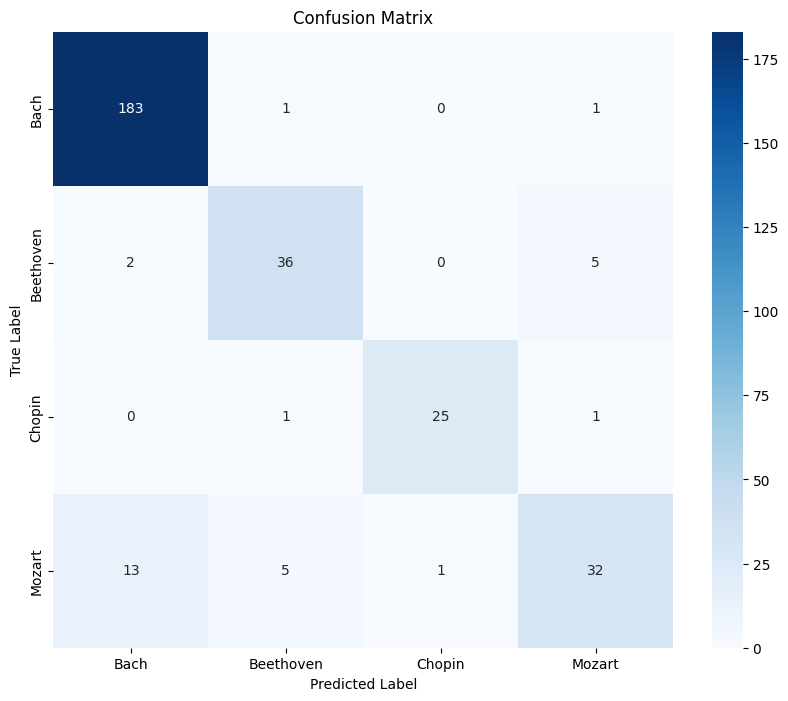

In [10]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
all_preds = []
all_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(batch_y.cpu().numpy())

print(f'Final Test Accuracy: {correct / total:.4f}')

# Plot training loss and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# plot confusion matrix
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()